In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
# Define dataset paths
test_dir = "/content/drive/MyDrive/Dataset/FruitinAmazon/FruitinAmazon/test"
train_dir = "/content/drive/MyDrive/Dataset/FruitinAmazon/FruitinAmazon/train"

In [5]:
img_width = 128
img_height = 128
# Function to load images without resizing
def load_images_from_folder(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Sorted class names
    class_map = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(folder, class_name)
        label = class_map[class_name]

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)

            # Load image in original size without resizing
            img = Image.open(img_path)
            img = img.resize((img_width, img_height)) # Resize to (28,28)
            img = np.array(img) / 255.0  # Normalize to [0,1]
            images.append(img)
            labels.append(label)
    return np.array(images), np.array(labels)




Training set: (90, 128, 128, 3), Labels: (90, 10)
Testing set: (30, 128, 128, 3), Labels: (30, 10)


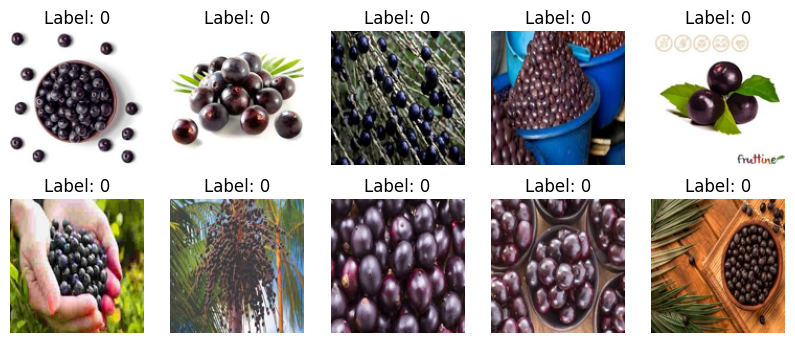

In [6]:
# Load training and testing datasets
x_train, y_train = load_images_from_folder(train_dir)
x_test, y_test = load_images_from_folder(test_dir)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Print dataset shape
print(f"Training set: {x_train.shape}, Labels: {y_train.shape}")
print(f"Testing set: {x_test.shape}, Labels: {y_test.shape}")

# Visualize some images
plt.figure(figsize=(10, 4))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis("off")

plt.show()


In [7]:
print(x_train.shape)
print(y_train.shape)

(90, 128, 128, 3)
(90, 10)


In [8]:
model = keras.Sequential([
layers.Conv2D(32, (3, 3), activation="relu", input_shape=(x_train.shape[1], x_train.shape[2], 3)),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(64, (3, 3), activation="relu"),
layers.MaxPooling2D((2, 2)),
layers.Conv2D(128, (3, 3), activation="relu"),
layers.MaxPooling2D((2, 2)),
# layers.Conv2D(256, (3, 3), activation="relu"),
# layers.MaxPooling2D((2, 2)),
layers.Flatten(),
layers.Dense(128, activation="relu"),
layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(optimizer="sgd",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [11]:
batch_size = 128
epochs =12

# Callbacks
callbacks = [
  keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
  keras.callbacks.EarlyStopping(monitor="val_loss", patience=4 ),
]

# Train model
history = model.fit(np.stack(x_train), y_train, epochs=epochs,batch_size=batch_size, validation_data=(np.stack(x_test), y_test),callbacks = callbacks,)

Epoch 1/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1889 - loss: 2.2829 - val_accuracy: 0.1333 - val_loss: 2.2084
Epoch 2/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2222 - loss: 2.2093 - val_accuracy: 0.2000 - val_loss: 2.1594
Epoch 3/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2333 - loss: 2.1593 - val_accuracy: 0.2000 - val_loss: 2.1186
Epoch 4/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2222 - loss: 2.1152 - val_accuracy: 0.2000 - val_loss: 2.0782
Epoch 5/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2000 - loss: 2.0722 - val_accuracy: 0.2333 - val_loss: 2.0415
Epoch 6/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.1889 - loss: 2.0315 - val_accuracy: 0.2333 - val_loss: 2.0069
Epoch 7/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.2000 - loss: 1.9938 - val_accuracy: 0.2333 - val_loss: 1.9743
Epoch 8/12
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2111 - loss: 1.9585 - val_accuracy: 0.2333 - val_loss: 1.9439
Epoch 9/12
1/1 ━

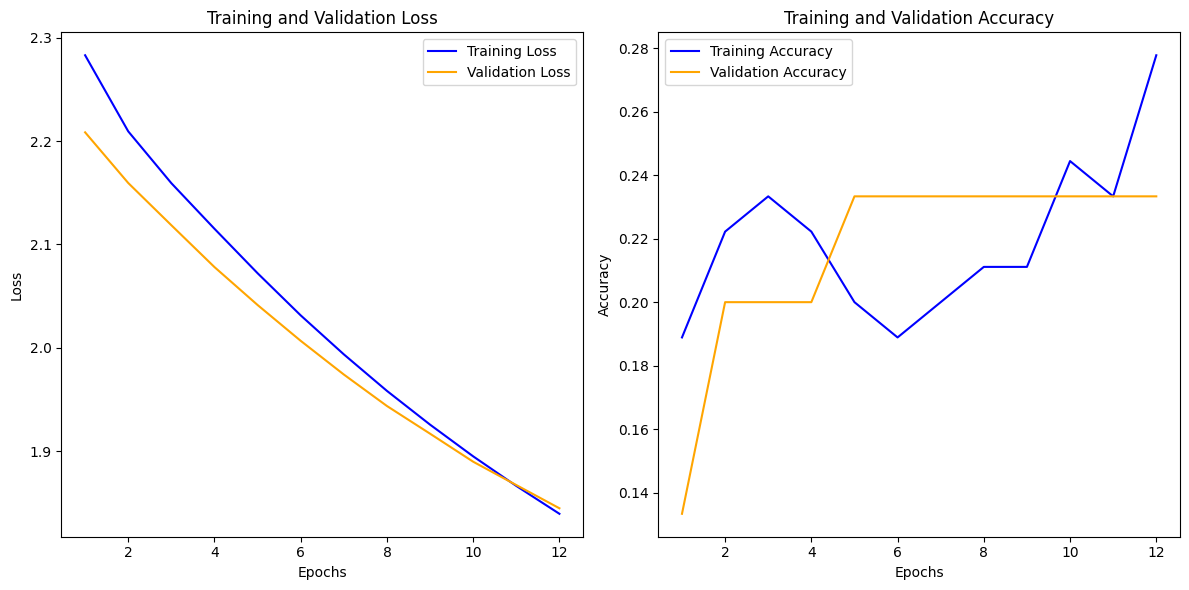

In [12]:
import matplotlib.pyplot as plt

# Extracting training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Extracting training and validation accuracy (if metrics were specified)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy', color='blue')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Evaluate model
test_loss, test_acc = model.evaluate(np.stack(x_test), y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.2333 - loss: 1.8451
Test Accuracy: 23.33%
